In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==============================
# 1. Importación de librerías
# ==============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set(style="whitegrid")


In [4]:
# ==============================
# 2. Cargar Dataset
# ==============================
file_path = "/content/drive/MyDrive/OnlineRetail.csv"   # Ajusta si tu archivo está en otra carpeta

df = pd.read_csv(file_path, encoding="ISO-8859-1")

print("\nDimensiones:", df.shape)
print(df.head())


Dimensiones: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


In [5]:
# =========================
# 4. Limpieza de Datos
# =========================
df.dropna(subset=["CustomerID"], inplace=True)

df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
#Conversion de string a fecha para realizar cálculos
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True)
#Agregar columna TotalAmount (Cantidad * Precio)
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

In [6]:
# ===============================
# 5. Creación de Variables RFM
# ===============================

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
#Creación de una Tabla RFM (Recency, Frequency, Monetary)
#comportamiento de cada cliente en tres métricas clave para luego poder segmentarlos
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

print("\nRFM Head")
print(rfm.head())


RFM Head
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


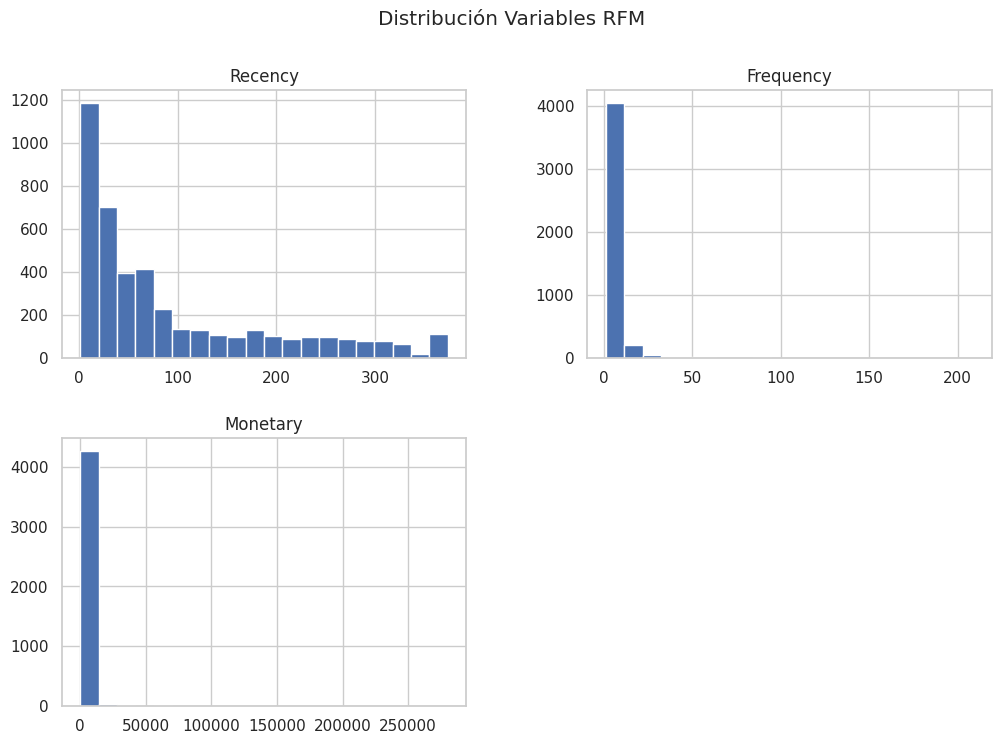

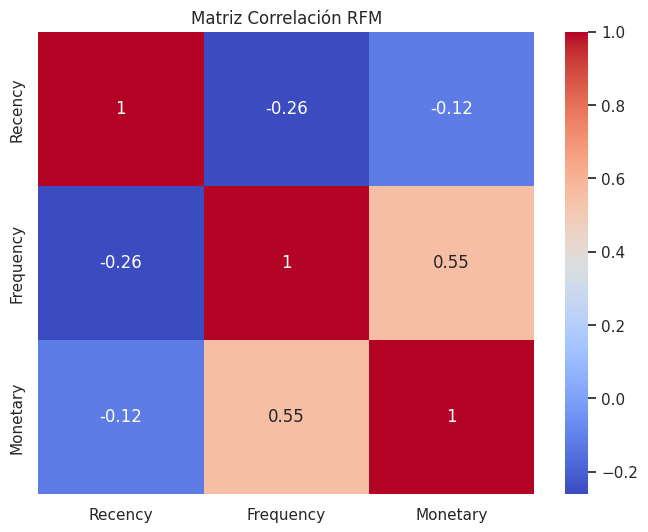

In [7]:
# ====================================
# 6. Exploratory Data Analysis (EDA)
# ====================================

rfm.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribución Variables RFM")
#save_plot("distribucion_rfm.png")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz Correlación RFM")
#save_plot("matriz_correlacion_rfm.png")
plt.show()

In [8]:
# =========================
# 7. Preprocesamiento
# =========================

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

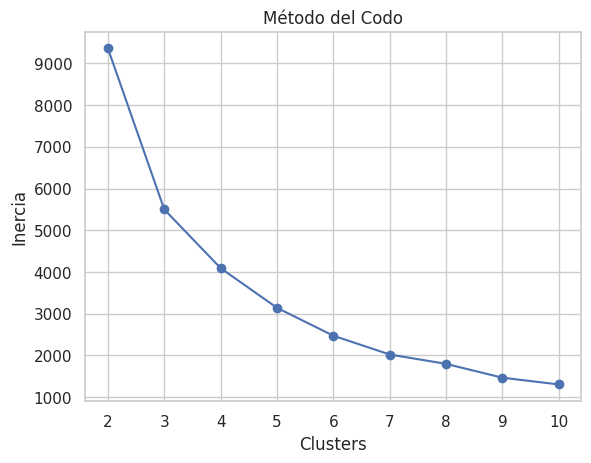

In [9]:
# =========================
# 8. Método del Codo (K-Means)
# =========================

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.title("Método del Codo")
plt.xlabel("Clusters")
plt.ylabel("Inercia")
#save_plot("elbow_kmeans.png")
plt.show()

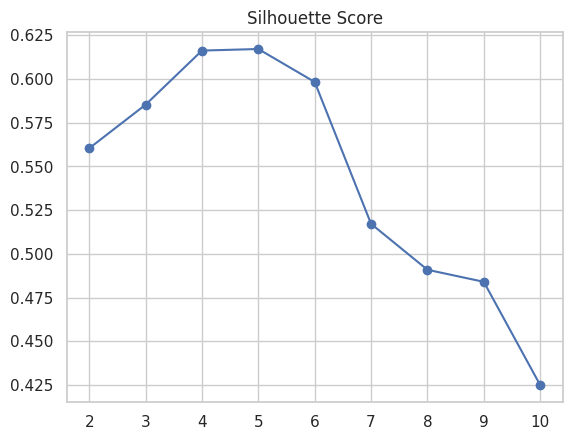

In [10]:
# =========================
# 9. Silhouette Score
# =========================

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Score")
#save_plot("silhouette_kmeans.png")
plt.show()

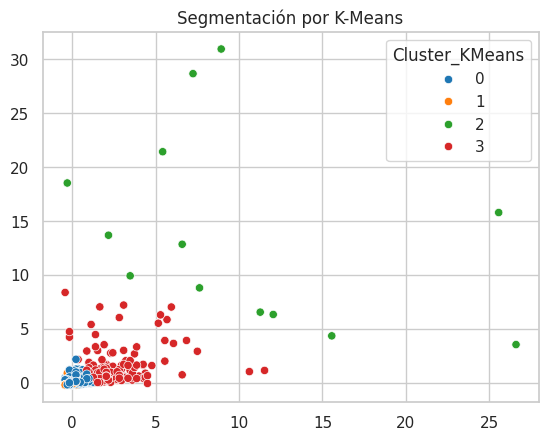

,Recency,Frequency,Monetary
Cluster_KMeans,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [11]:
# =========================
# 10. K-Means Final
# =========================

k_optimo = 4

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster_KMeans"] = kmeans.fit_predict(rfm_scaled)

sns.scatterplot(x=rfm_scaled[:, 1], y=rfm_scaled[:, 2], hue=rfm['Cluster_KMeans'], palette='tab10')
plt.title('Segmentación por K-Means')
plt.show()

rfm.groupby('Cluster_KMeans')[['Recency', 'Frequency', 'Monetary']].mean()


Clusters DBSCAN: 2


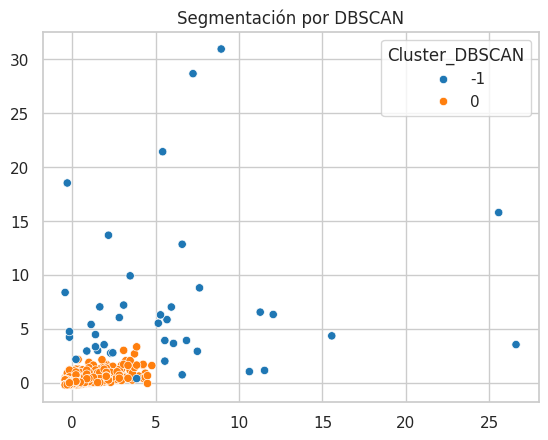

,Recency,Frequency,Monetary
Cluster_DBSCAN,,,
-1,34.243902,49.024390,66319.180488
0,93.092623,3.845008,1441.080173


In [12]:
# =========================
# 11. DBSCAN
# =========================

dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(rfm_scaled)

print("\nClusters DBSCAN:",
      len(set(rfm["Cluster_DBSCAN"])) -
      (1 if -1 in rfm["Cluster_DBSCAN"] else 0))

sns.scatterplot(x=rfm_scaled[:, 1], y=rfm_scaled[:, 2], hue=rfm['Cluster_DBSCAN'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()

rfm['Cluster_DBSCAN'].value_counts()
rfm.groupby('Cluster_DBSCAN')[['Recency', 'Frequency', 'Monetary']].mean()

In [22]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN sin atípicos
rfm_no_noise = rfm[rfm['Cluster_DBSCAN'] != -1]
rfm_no_noise.groupby('Cluster_DBSCAN')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
Cluster_DBSCAN,,,
0,93.092623,3.845008,1441.080173


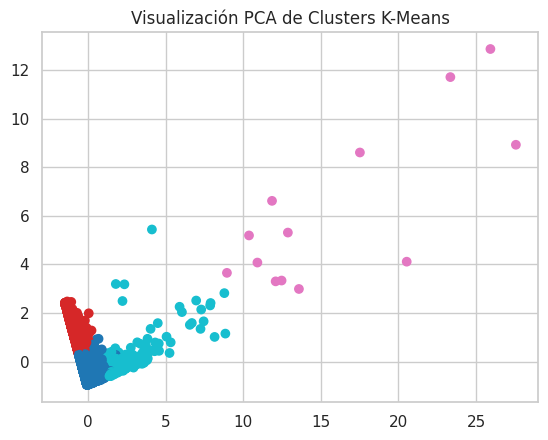

In [13]:
# =========================
# 12. PCA Visualización
# =========================

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster_KMeans'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()




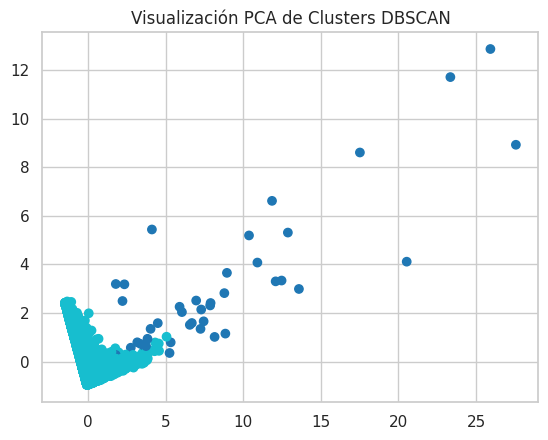

In [14]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster_DBSCAN'], cmap='tab10')
plt.title('Visualización PCA de Clusters DBSCAN')
plt.show()


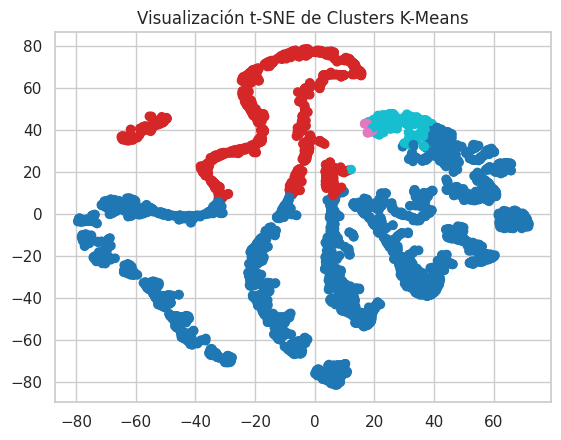

In [15]:
# =========================
# 12. t-SNE Visualización
# =========================

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(rfm_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=rfm['Cluster_KMeans'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.show()

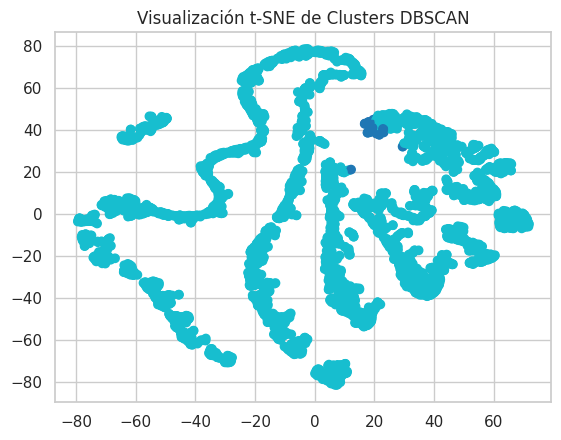

In [16]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(rfm_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=rfm['Cluster_DBSCAN'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters DBSCAN')
plt.show()

In [29]:
# Análisis
print("Clusters únicos KMeans:", rfm['Cluster_KMeans'].unique())
print("Clusters únicos DBSCAN:", rfm['Cluster_DBSCAN'].unique())

Clusters únicos KMeans: [3 0 1 2]
Clusters únicos DBSCAN: [-1  0]


In [37]:
# ================================
# 14. Perfilamiento de Clusters
# ================================
# Resumen Clusters
print("\nResumen Clusters")
kmeans_summary = rfm.groupby("Cluster_KMeans").mean()
print("\nResumen KMeans")
print(kmeans_summary)

dbscan_filtered = rfm[rfm["Cluster_DBSCAN"] != -1]
dbscan_summary = dbscan_filtered.groupby("Cluster_DBSCAN").mean()
print("\nResumen DBSCAN")
print(dbscan_summary)



Resumen Clusters

Resumen KMeans
                   Recency  Frequency       Monetary  Cluster_DBSCAN
Cluster_KMeans                                                      
0                43.702685   3.682711    1359.049284       -0.000327
1               248.075914   1.552015     480.617480        0.000000
2                 7.384615  82.538462  127338.313846       -1.000000
3                15.500000  22.333333   12709.090490       -0.132353

Resumen DBSCAN
                  Recency  Frequency     Monetary  Cluster_KMeans
Cluster_DBSCAN                                                   
0               93.092623   3.845008  1441.080173        0.371887
